In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch

os.chdir('..')
from models.architectures.encoders.fc import PTFCEncoder
from models.architectures.decoders.fc import PTFCDecoder
from models.pt_vae import PTVAE as VAE
from multiprocessing import cpu_count
from trainer import VAETrainer
import json
import numpy as np
from utils.nn_utils import  set_seed

print(os.getcwd())
# model parameters

SEED = 50
set_seed(SEED)
INPUT_DIM = 2000
HIDDEN_DIM = 500
LATENT_DIM = 50

# training parameters
BATCH_SIZE = 500
NUM_EPOCHS = 1000
LEARNING_RATE = 5e-5
CUDA = torch.cuda.is_available()
# beta template for hfvae (gammma, 1, alpha, beta, 0)
parameters = {'SEED':SEED, 'INPUT_DIM':INPUT_DIM, 'HIDDEN_DIM':HIDDEN_DIM, 'LATENT_DIM':LATENT_DIM, 'BATCH_SIZE':BATCH_SIZE,
              'NUM_EPOCHS':NUM_EPOCHS, 'LEARNING_RATE':LEARNING_RATE}
DATA_PATH = 'resources/datasets/20news/'
SAVE_PATH = 'results/nvdm/probtorch/'


/home/dorian/FER/master_thesis/src/base


### Data loading

In [3]:
# data loading
kwargs = {'num_workers': cpu_count(), 'pin_memory': True} if CUDA else {'num_workers': cpu_count()}
labels = json.load(open(DATA_PATH+'topics.json', 'r'))
train_data = np.load(DATA_PATH+'train.npy')
train_labels = np.load(DATA_PATH+'train.labels.npy')
test_data = np.load(DATA_PATH+'test.npy')
test_labels = np.load(DATA_PATH+'test.labels.npy')


train_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(train_data, train_labels)],
                                         batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader([[x,y] for x,y in zip(test_data, train_labels)],
                                        batch_size=BATCH_SIZE, shuffle=True, **kwargs)


### Model training

In [3]:
# model training
from utils.file_handling import MultiOutput
import sys
f = open(SAVE_PATH+'training_output.txt','w')
original = sys.stdout
# write to output and save output to file
sys.stdout = MultiOutput(sys.stdout, f)

enc = PTFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dec = PTFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE)
model = VAE(encoder=enc, decoder=dec)
model.cuda().double()
optimizer =  torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
device = torch.device("cuda" if CUDA else "cpu")

VAETrainer(model, device, train_loader, test_loader, save_model_path=SAVE_PATH, probtorch=True, included_labels=True).run(optimizer, NUM_EPOCHS)
# save parameters
json.dump(parameters, open(SAVE_PATH+'parameters.json', 'w'))
# return output to normal
sys.stdout = original
f.close()



Train Epoch:  1 [     0/ 11314 (  0%)]	Loss: 298.050029
Train Epoch:  1 [  5000/ 11314 ( 43%)]	Loss: 360.561165
Train Epoch:  1 [ 10000/ 11314 ( 87%)]	Loss: 342.925659
====> Epoch: 1 Average loss: 340.9601
====> Test set loss: 315.6635
Train Epoch:  2 [     0/ 11314 (  0%)]	Loss: 351.716561
Train Epoch:  2 [  5000/ 11314 ( 43%)]	Loss: 345.797835
Train Epoch:  2 [ 10000/ 11314 ( 87%)]	Loss: 334.017849
====> Epoch: 2 Average loss: 334.4343
====> Test set loss: 312.0600
Train Epoch:  3 [     0/ 11314 (  0%)]	Loss: 373.270709
Train Epoch:  3 [  5000/ 11314 ( 43%)]	Loss: 342.438238
Train Epoch:  3 [ 10000/ 11314 ( 87%)]	Loss: 311.096895
====> Epoch: 3 Average loss: 336.8447
====> Test set loss: 313.5308
Train Epoch:  4 [     0/ 11314 (  0%)]	Loss: 346.192045
Train Epoch:  4 [  5000/ 11314 ( 43%)]	Loss: 287.263374
Train Epoch:  4 [ 10000/ 11314 ( 87%)]	Loss: 336.490855
====> Epoch: 4 Average loss: 332.0875
====> Test set loss: 313.4675
Train Epoch:  5 [     0/ 11314 (  0%)]	Loss: 320.564972


### Restore model

In [4]:
# EVALUATION
# model loading
enc = PTFCEncoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM)
dec = PTFCDecoder(latent_dim=LATENT_DIM, output_dim=INPUT_DIM, batch_size=BATCH_SIZE)
model = VAE(encoder=enc, decoder=dec)
model.load_state_dict(torch.load(SAVE_PATH+'model.pt'))
model.cuda().double()
model.eval()


PTVAE(
  (encoder): PTFCEncoder(
    (main): Sequential(
      (0): Linear(in_features=2000, out_features=500, bias=True)
      (1): ReLU()
    )
    (mu): Linear(in_features=500, out_features=50, bias=True)
    (logvar): Linear(in_features=500, out_features=50, bias=True)
  )
  (decoder): PTFCDecoder(
    (main): Sequential(
      (0): Linear(in_features=50, out_features=2000, bias=True)
      (1): Softmax(dim=-1)
    )
  )
)

### Evaluation
#### t-SNE

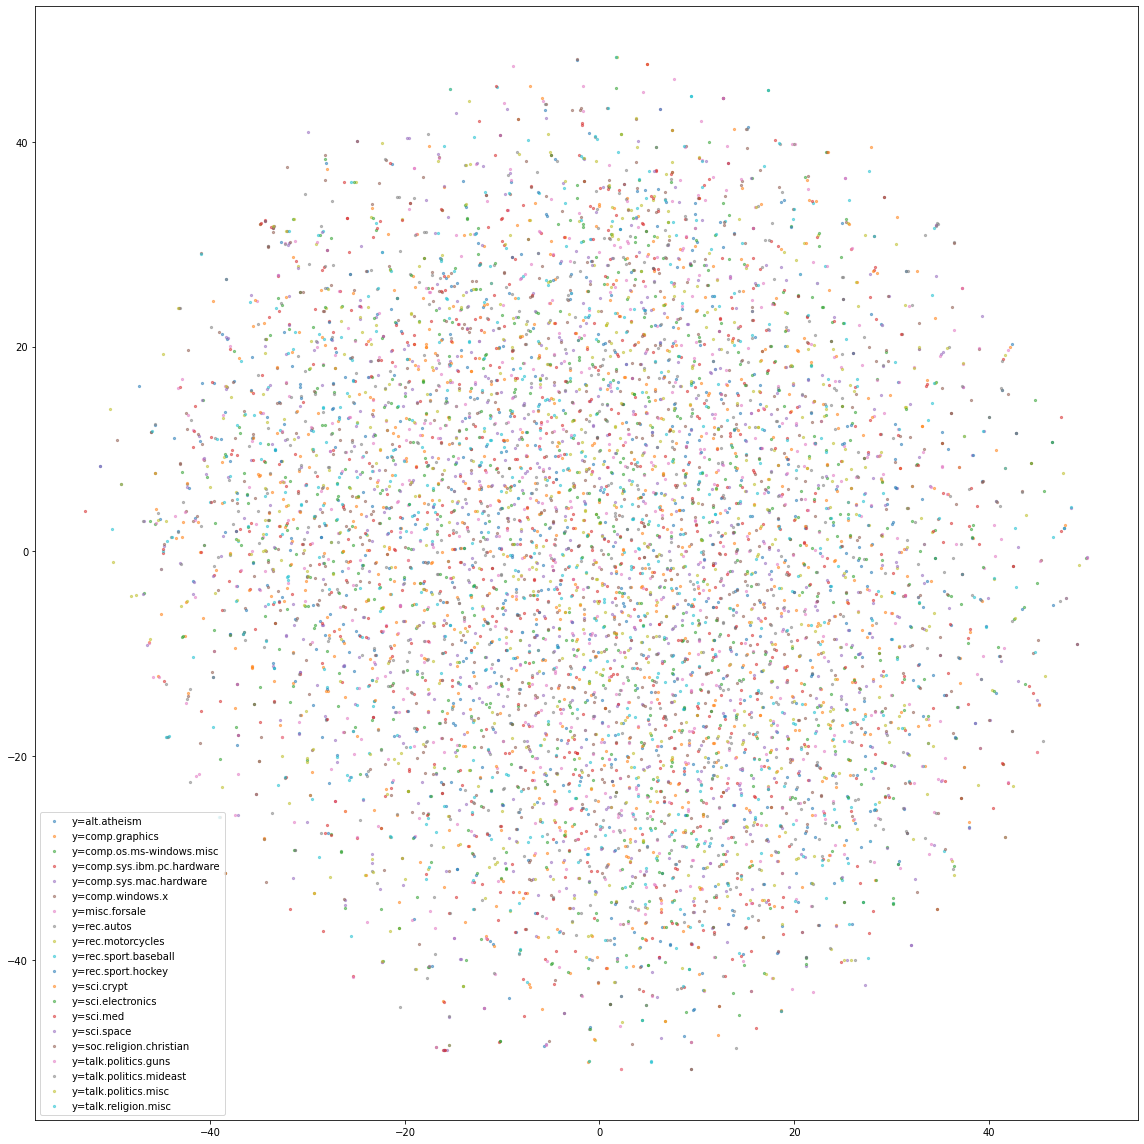

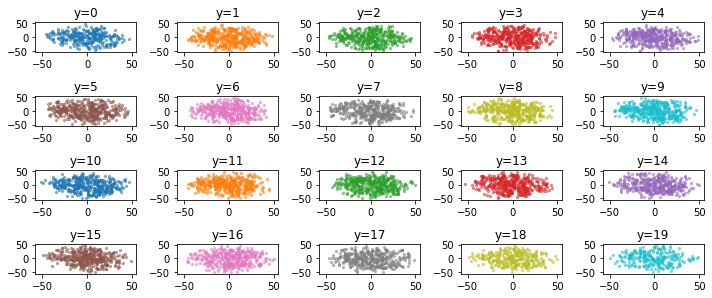

In [6]:
# Embedding visualization
# t-sne
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import numpy as np
zs = []
xs = []
ys = []

for (x, y) in test_loader:
    if len(x) == BATCH_SIZE:
        q = model.encoder(x.cuda().double())
        z = q['z'].value.cpu().detach().numpy()
        zs.append(z.reshape(-1, LATENT_DIM))
        xs.append(x.numpy())
        ys.append(y.numpy())

zs = np.concatenate(zs, 0)
xs = np.concatenate(xs, 0)
ys = np.concatenate(ys, 0)
zs_mean = zs.mean(0)
zs_std = zs.std(0)

%matplotlib inline
zs2 = TSNE().fit_transform(zs)

fig = plt.figure(figsize=(16,16))
ax = plt.gca()

colors = []
for k in range(len(labels)):
    m = (ys==k)
    p = ax.scatter(zs2[m, 0], zs2[m, 1], label='y=%s'%labels[k], alpha=0.5, s=5)
    colors.append(p.get_facecolor())
ax.legend()
fig.tight_layout()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
# save figure
plt.savefig(SAVE_PATH+'tsne.png')


# for each class independently
fig = plt.figure(figsize=(10,4.25))

for k in range(len(labels)):
    ax = plt.subplot(4,5,k+1)
    m = (ys == k)
    ax.scatter(zs2[m, 0], zs2[m, 1], alpha=0.5, s=5, c=colors[k])
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_title('y=%d' % k)

fig.tight_layout()
plt.savefig(SAVE_PATH+'tsne_by_class.png')



#### z-histograms to see learned distributions
TODO



#### Correlation plot (z)

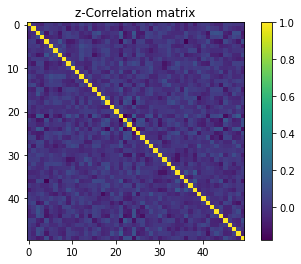

In [8]:
#correlation plot
cov_matrix = np.corrcoef(zs.T)
plt.imshow(cov_matrix, interpolation='None')
plt.title('z-Correlation matrix')
plt.colorbar()
plt.savefig(SAVE_PATH+'z-correlations.png')



#### Top words

In [9]:
from evaluation.topics import print_top_words
# save output
f = open(SAVE_PATH+'topics.txt','w')
original = sys.stdout
sys.stdout = MultiOutput(sys.stdout, f)
# Top words in topics
# load the vocab
vocab = json.load(open(DATA_PATH+'vocab.json','r'))
idx2word = {i:vocab[i] for i in range(len(vocab))}
# get weights of the decoder
emb = model.decoder.main[0].weight.cpu().detach().numpy().T
print_top_words(emb, idx2word)
sys.stdout = original
f.close()


--------------- Topics ------------------
relative shuttle ken turbo rate keith fuel engine failed percentage
roger crypto yeah chips phone dealers firearms keith sale rangers
surrender citizens banks killed government drugs federal anti humans army
deleted shot blood yeah age die enjoy jesus cold humans
running mac video bad sound problem machine fax luck directory
period zone turkish mission constitution armenia total bodies printed planned
pages warrant resource property postscript region map turkey documents motif
corner button disks objects hole location screen storage unit bits
news status islamic joseph mary international kids school west battle
part people message method occur response involved fire failed public
stats sexual evidence homosexuality percentage women goals thread print argument
detroit universe bible truth adams toronto wings islam religions christians
arab fighting drivers boards tim sun van cards adam israeli
chips keys chip escrow serial slower europe security

#### NPMI

In [10]:
from evaluation.topics import npmi_coherence_score
import pickle
X_raw = json.load(open(DATA_PATH+'X_raw.json','r'))
decoder_weight = model.decoder.main[0].weight.detach().cpu()
top_words = 10
topics = [
    [idx2word[item.item()] for item in topic]
    for topic in decoder_weight.topk(10, dim=0)[1].t()
]
word_frequencies = pickle.load(open(DATA_PATH+'word_frequencies.pkl','rb'))
joint_word_frequencies = pickle.load(open(DATA_PATH+'jointword_frequencies.pkl','rb'))
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))
print('Max: %f'%max(npmi_per_topic))
print('Topic : %s'%(' '.join(topics[np.argmax(npmi_per_topic)])))
# save results
json.dump({'npmi_per_topic':npmi_per_topic, 'avg_npmi':sum(npmi_per_topic)/len(npmi_per_topic)},open(SAVE_PATH+'npmi.json','w'))



[0.09124268748733899, -0.031171296210366854, 0.20239366783948703, 0.11386964190166891, 0.18664103643229316, 0.27545796817738155, 0.19326193649233075, 0.23574531855459566, 0.1641252453458826, 0.21960762051728647, 0.1205213360631104, 0.02751000229417134, -0.0007846287985999271, 0.21623349969074937, 0.2316764227161168, 0.2523521779780884, -0.0545165183743493, 0.17272300925177353, 0.2525532606356348, 0.18971879378894707, 0.10716249284148673, 0.20717483276611853, 0.24816624666823642, 0.18462724282170848, 0.15695683212748418, 0.2806406152014786, 0.14430895346117112, 0.11516016066790018, -0.0046612035920840286, 0.15069246369486136, 0.2192922474848433, 0.2176041571246705, 0.1800063575708589, -0.20524086239443504, 0.24880903877633803, -0.12422107280806717, 0.4000992529387836, 0.17563013954795, 0.21781781708908884, 0.16570939321542094, 0.24756710740174048, -0.3211961641538312, 0.1857521156019555, 0.2163050940659153, 0.15093345010998938, 0.12747420384194755, 0.16112635341972448, 0.198030030177709

#### LDA for comparison

In [18]:
import gensim
# training classic LDA just for comparison
corpus = gensim.matutils.Dense2Corpus(train_data, documents_columns=False)
lda = gensim.models.LdaMulticore(corpus=corpus,
                                 id2word=idx2word,
                                 num_topics=50,
                                 random_state=100,
                                 passes=10)

In [19]:
coherence_model = gensim.models.CoherenceModel(model=lda,
                                               texts=X_raw,
                                               dictionary=gensim.corpora.dictionary.Dictionary.from_corpus(corpus, idx2word),
                                               coherence='c_npmi')
topic_coherences = coherence_model.get_coherence_per_topic()
print(topic_coherences)
print(sum(topic_coherences)/len(topic_coherences))

[0.05049653446593177, 0.018853839167305892, 0.13889612641516624, 0.022945950029298473, -0.0006003120676231906, 0.1428051110383231, 0.11315420450649968, 0.0603837412866034, -0.07631427244884832, 0.13477647813050067, -0.12113910056456596, 0.03452064847060468, -0.012526820374331515, 0.13433586922156424, 0.08481460233152115, -0.0046095948153488525, 0.14795521458271274, 0.0643200487789307, 0.09741848749268073, -0.028582443389426147, 0.013560249247074262, -0.029854817229828124, 0.17069680278113172, 0.041594051846695755, 0.023262740152461197, -0.015284992085027458, 0.02957366350989352, -0.012382081119426134, -0.0809209396639903, -0.05902062671151506, -0.03754023400933772, 0.054073430455275046, 0.044970844029611955, 0.004594873432606471, 0.11843654659168892, 0.05827839243050851, -0.12443164045021132, 0.018179347383259856, -0.06328050309834121, 0.003220650621897766, 0.018718541240538306, -0.009209533430282583, 0.09513379877887652, 0.16329721392069838, 0.024118672311393214, -0.06975283708929722,

In [21]:
# with my implementation
topics = lda.show_topics(num_topics=50, num_words=10, formatted=False)
topics = [[t[0] for t in topic[1]] for topic in topics]
npmi_per_topic = npmi_coherence_score(topics, word_frequencies, joint_word_frequencies)
print(npmi_per_topic)
print(sum(npmi_per_topic)/len(npmi_per_topic))
for topic in topics:
    print(topic)



[0.16410033369830448, 0.3111506547532112, 0.3114129065896065, 0.2532044613857142, 0.18540062448569977, 0.3571823886854365, 0.3122368409907439, 0.2697089955510378, 0.14553792552260353, 0.416451331905533, 0.19892567161221894, 0.27745537742764353, 0.20559272753652633, 0.340324700723863, 0.4240882933319373, 0.22213953829759964, 0.4676971884705831, 0.13982192371931396, 0.3665607427566965, 0.18697436442110582, 0.32289840459720787, 0.24979912838610635, 0.3740518835592937, 0.21790243274365118, 0.21180207632988513, 0.20816621490125248, 0.18736735069409186, 0.17593497473809364, 0.17990350537115046, 0.18011868130999345, 0.23890330528870785, 0.237629458728827, 0.16311259013485555, 0.16870227815922761, 0.3344769660198739, 0.23457751758471912, 0.15180438273571348, 0.17458782640347076, 0.1379065730339304, 0.28150057621561597, 0.1909182071256871, 0.28186802094285945, 0.26290095125736423, 0.4331352499031874, 0.15669152368152559, 0.14540524721734785, 0.18392229075549102, 0.14442045864007083, 0.121592459

#### Mutual informtaion - I(x,zd)

In [11]:
# mutual information
from evaluation.NPEET.npeet import entropy_estimators as ee
import warnings
warnings.filterwarnings("ignore")
mi = ee.mi(xs, zs)
micd = ee.micd(zs, xs)
print(mi)
print(micd)
# THIS IS EXTREMELY SLOW - takes almost as much as training the model

0.38429782557580333
0.22591102625038673


In [ ]:
# using sklearn
from sklearn.feature_selection import mutual_info_regression
# each component of z is treated as a continuous target variable (y)
# x are features, which are discrete
mis = []
for i in range(zs.shape[-1]):
    mi = mutual_info_regression(X=xs, y=zs[...,i], discrete_features=True).mean()
    print(mi)
    mis.append(mi)
print(mis)
print(np.mean(mis))
# also very slow - ~5min per dimension

0.0006332697304276079
0.0012150221756404595
0.0006841355330150861
0.0006358042489734839
0.0008735679972716653
0.0006930410157645273
0.0005927225468085475
0.0008304877877976529


#### Mutual information - I(yk,zd)